<a href="https://colab.research.google.com/github/harshvs4/Coding_Drill_Down_MNIST/blob/main/Exp2_LessParams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


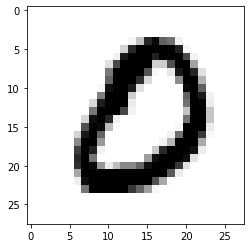

In [6]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[1].numpy().squeeze(), cmap='gray_r')

In [13]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 8, 3, padding = 0, bias = False),  # (1*26*26), (8*26*26), RF - 3*3
        nn.ReLU(),

        nn.Conv2d(8, 16, 3, padding = 0, bias = False), #(8*24*24), (16*24*24), RF - 5*5
        nn.ReLU()
    )

    #Transition block
    self.trans1 = nn.Sequential(
        nn.MaxPool2d(2, 2) , #(16*12*12), RF - 10*10
        nn.Conv2d(16, 8, 1, padding = 0, bias = False),  #(16*12*12), (8*12*12), RF - 10*10
        nn.ReLU()
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(8, 10, 3, padding = 0, bias = False), #(8*10*10), (10*10*10), RF - 12*12
        nn.ReLU(),

        nn.Conv2d(10, 10, 3, padding = 0, bias = False), #(10*8*8), (10*8*8), RF - 14*14
        nn.ReLU(),

        nn.Conv2d(10, 16, 3, padding = 0, bias = False), #(10*8*8),(16*8*8), RF - 14*14 
        nn.ReLU(),
    )

    #Output block
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 10, 1, padding = 0, bias = False) #(16*6*6), (10*6*6), RF - 14*14
    )
    self.avgpool2d = nn.AvgPool2d(6,6) #RF - 28*28

  def forward(self, x):
       x = self.conv1(x)
       x = self.trans1(x)
       x = self.conv2(x)
       x = self.conv3(x)
       x = self.avgpool2d(x)
       x = x.view(-1,10)
       return F.log_softmax(x,dim=1)

In [14]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6            [-1, 8, 12, 12]             128
              ReLU-7            [-1, 8, 12, 12]               0
            Conv2d-8           [-1, 10, 10, 10]             720
              ReLU-9           [-1, 10, 10, 10]               0
           Conv2d-10             [-1, 10, 8, 8]             900
             ReLU-11             [-1, 10, 8, 8]               0
           Conv2d-12             [-1, 16, 6, 6]           1,440

In [15]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [16]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=2.2946338653564453 Batch_id=468 Accuracy=9.91: 100%|██████████| 469/469 [00:17<00:00, 26.20it/s]



Test set: Average loss: 2.3000, Accuracy: 1009/10000 (10.09%)

EPOCH: 2


Loss=0.32085558772087097 Batch_id=468 Accuracy=47.50: 100%|██████████| 469/469 [00:12<00:00, 37.86it/s]



Test set: Average loss: 0.3100, Accuracy: 8995/10000 (89.95%)

EPOCH: 3


Loss=0.1654035598039627 Batch_id=468 Accuracy=91.30: 100%|██████████| 469/469 [00:12<00:00, 37.46it/s]



Test set: Average loss: 0.1814, Accuracy: 9461/10000 (94.61%)

EPOCH: 4


Loss=0.07316998392343521 Batch_id=468 Accuracy=94.21: 100%|██████████| 469/469 [00:12<00:00, 37.79it/s]



Test set: Average loss: 0.1484, Accuracy: 9540/10000 (95.40%)

EPOCH: 5


Loss=0.18045395612716675 Batch_id=468 Accuracy=95.36: 100%|██████████| 469/469 [00:12<00:00, 38.00it/s]



Test set: Average loss: 0.1237, Accuracy: 9623/10000 (96.23%)

EPOCH: 6


Loss=0.22707687318325043 Batch_id=468 Accuracy=96.13: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]



Test set: Average loss: 0.1081, Accuracy: 9669/10000 (96.69%)

EPOCH: 7


Loss=0.24783378839492798 Batch_id=468 Accuracy=96.62: 100%|██████████| 469/469 [00:12<00:00, 38.38it/s]



Test set: Average loss: 0.0970, Accuracy: 9708/10000 (97.08%)

EPOCH: 8


Loss=0.150355264544487 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:12<00:00, 37.81it/s]



Test set: Average loss: 0.0918, Accuracy: 9729/10000 (97.29%)

EPOCH: 9


Loss=0.0800296887755394 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:12<00:00, 38.22it/s]



Test set: Average loss: 0.0810, Accuracy: 9746/10000 (97.46%)

EPOCH: 10


Loss=0.10256022214889526 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:12<00:00, 37.15it/s]



Test set: Average loss: 0.0940, Accuracy: 9711/10000 (97.11%)

EPOCH: 11


Loss=0.1617264598608017 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:12<00:00, 37.22it/s]



Test set: Average loss: 0.0686, Accuracy: 9783/10000 (97.83%)

EPOCH: 12


Loss=0.01844613254070282 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:12<00:00, 37.22it/s]



Test set: Average loss: 0.0947, Accuracy: 9715/10000 (97.15%)

EPOCH: 13


Loss=0.02247297577559948 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:12<00:00, 37.94it/s]



Test set: Average loss: 0.0602, Accuracy: 9808/10000 (98.08%)

EPOCH: 14


Loss=0.03532371297478676 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]



Test set: Average loss: 0.0576, Accuracy: 9823/10000 (98.23%)

EPOCH: 15


Loss=0.043007392436265945 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:12<00:00, 37.57it/s]



Test set: Average loss: 0.0694, Accuracy: 9791/10000 (97.91%)

